In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.jaywalk_gym.jaywalk_env import EnvParams, JaywalkEnv


easy_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
)
easy_env = JaywalkEnv(easy_params)

In [3]:
medium_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
    num_lane_groups=3,
    max_vehicles=30,
    p_vehicle_spawn=0.8,
    p_vehicle_stop=0.5,
)
medium_env = JaywalkEnv(medium_params)

In [4]:
hard_params = EnvParams(
    use_traffic_light=True,
    max_reward=100,
    wait_reward=-1,
    death_reward=-50,
    num_lane_groups=4,
    max_vehicles=50,
    p_vehicle_spawn=0.9,
    p_vehicle_stop=0.3,
)
hard_env = JaywalkEnv(hard_params)

/Users/vatsalmehta/Desktop/jaywalker-rl/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating easy
Model and optimizer successfully loaded from ../../checkpoints/final_acer/easy.pt


/Users/vatsalmehta/Desktop/jaywalker-rl/src/agents/acer/acer_agent.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path, map_location=self

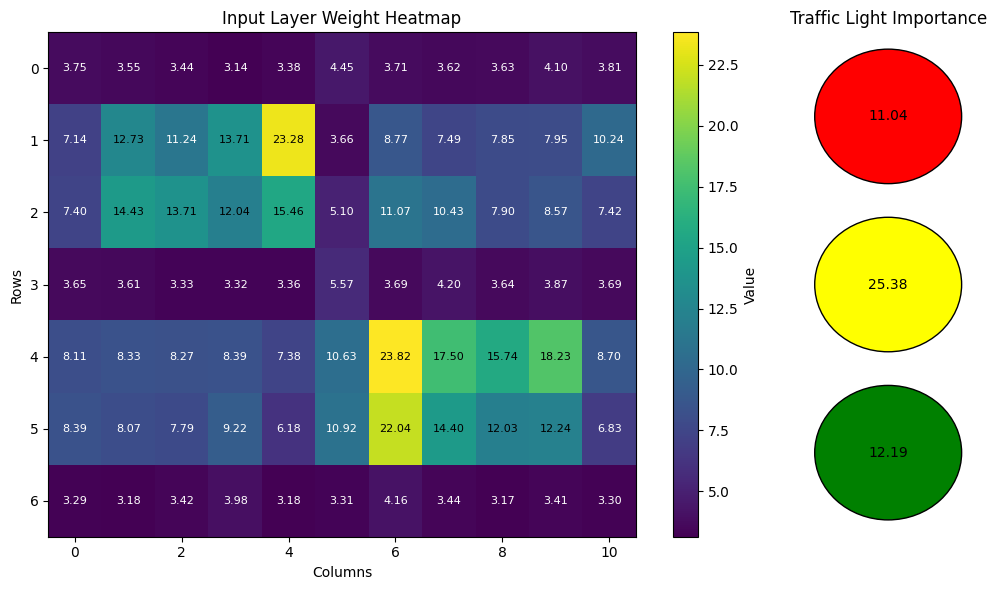

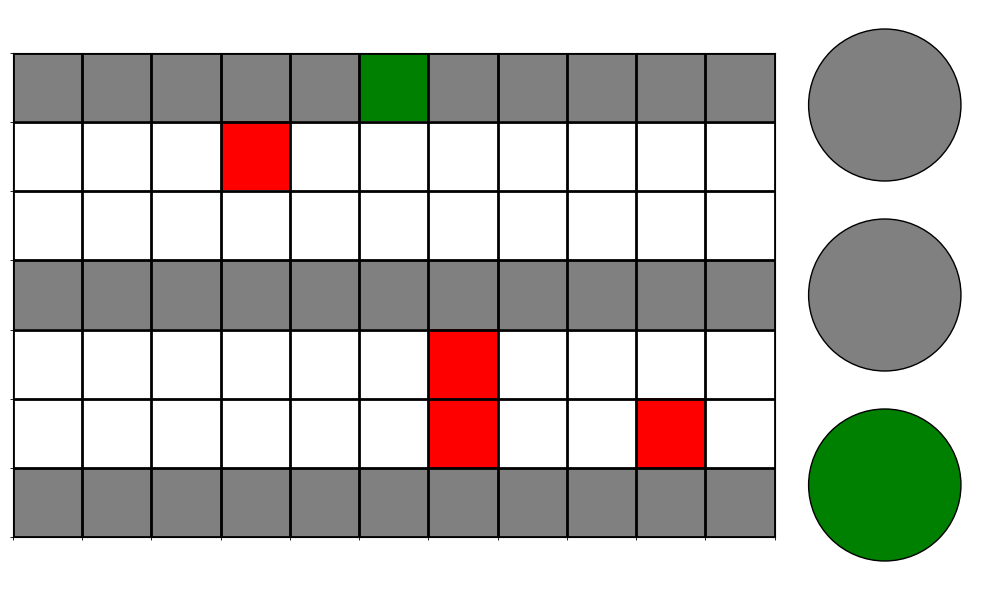

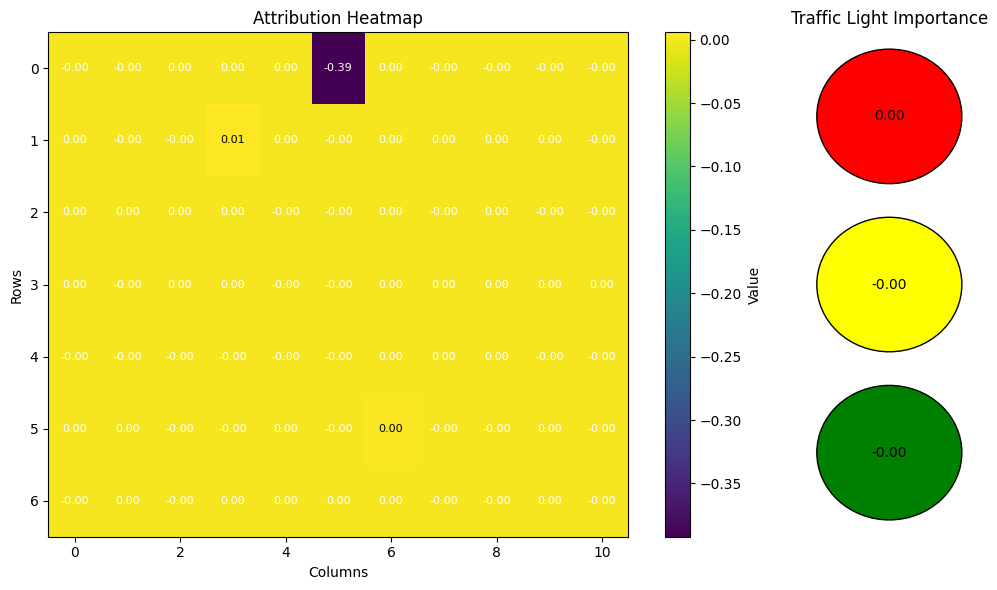

Evaluating medium
Model and optimizer successfully loaded from ../../checkpoints/final_acer/medium.pt


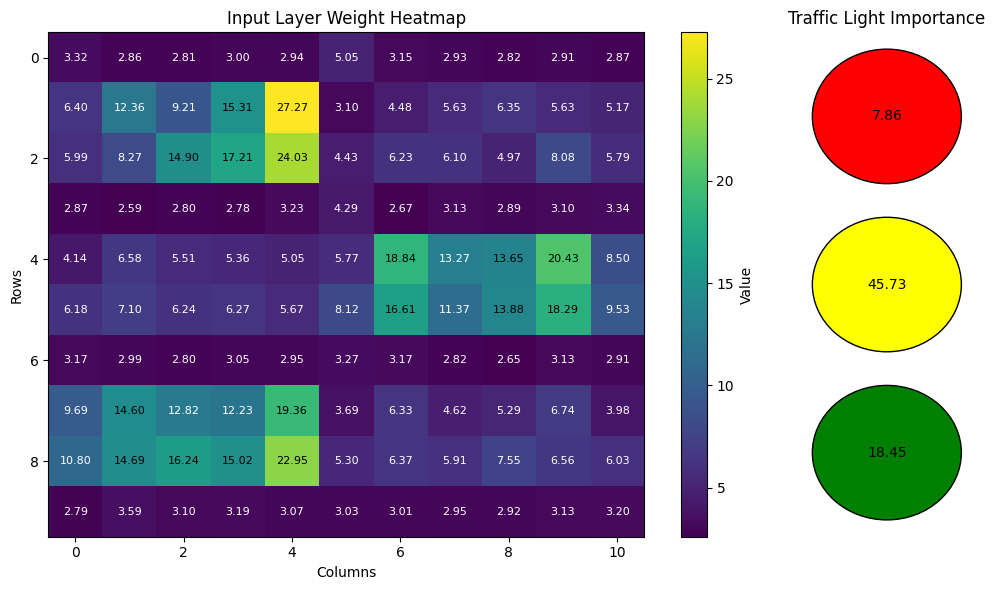

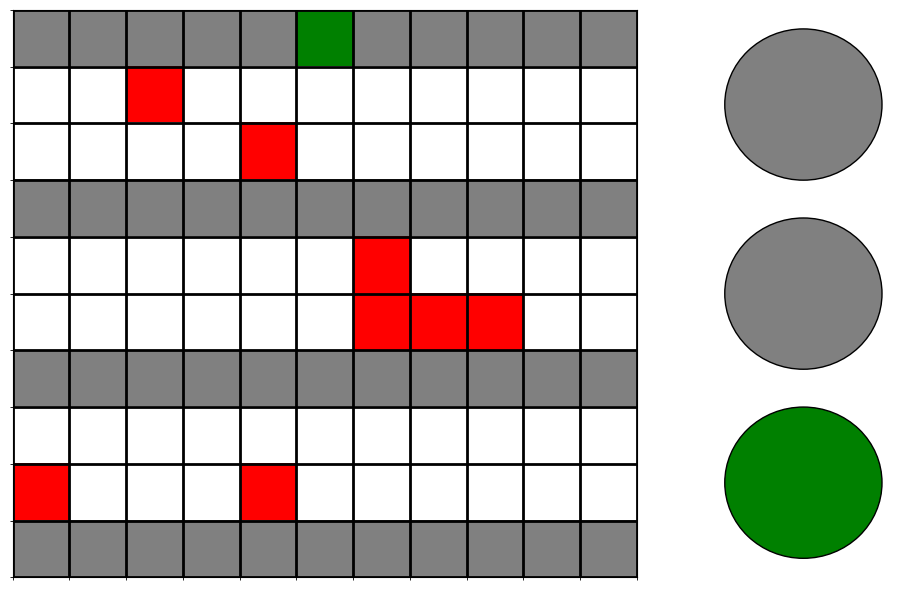

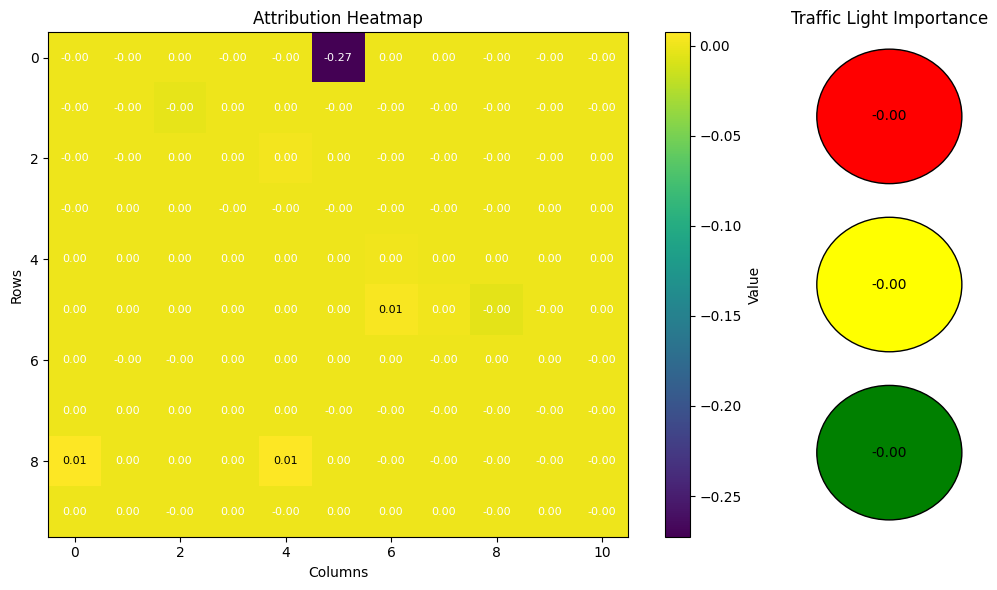

Evaluating hard
Model and optimizer successfully loaded from ../../checkpoints/final_acer/hard.pt


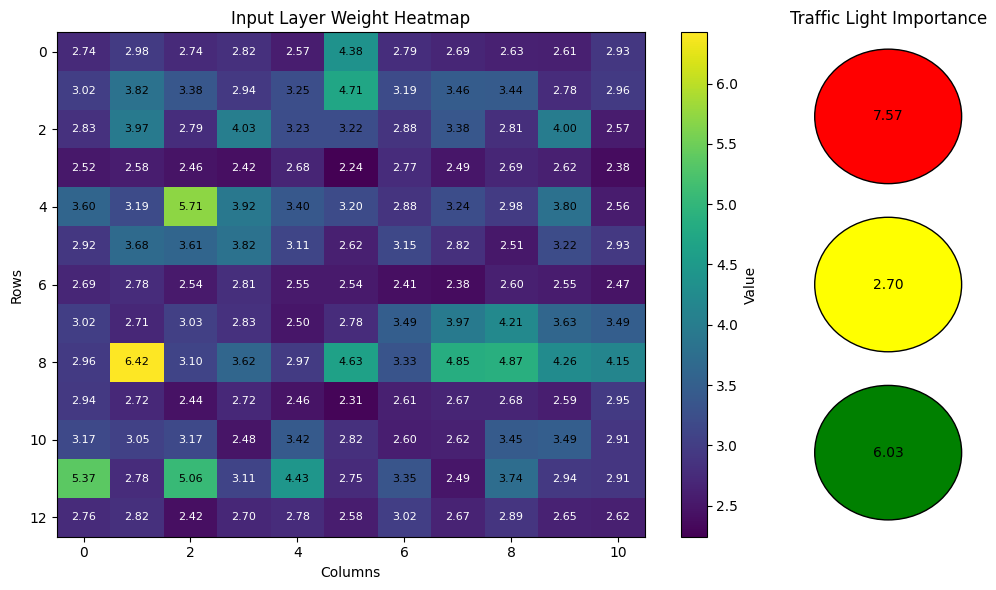

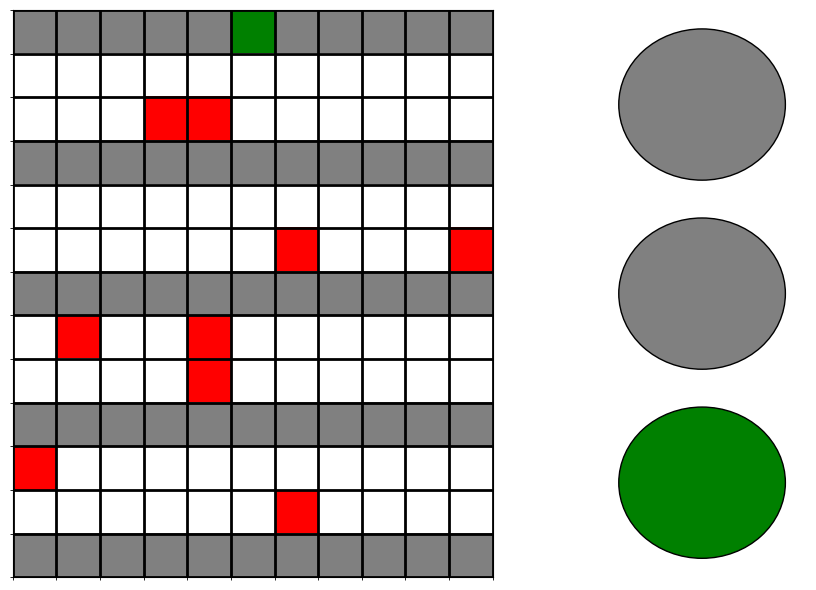

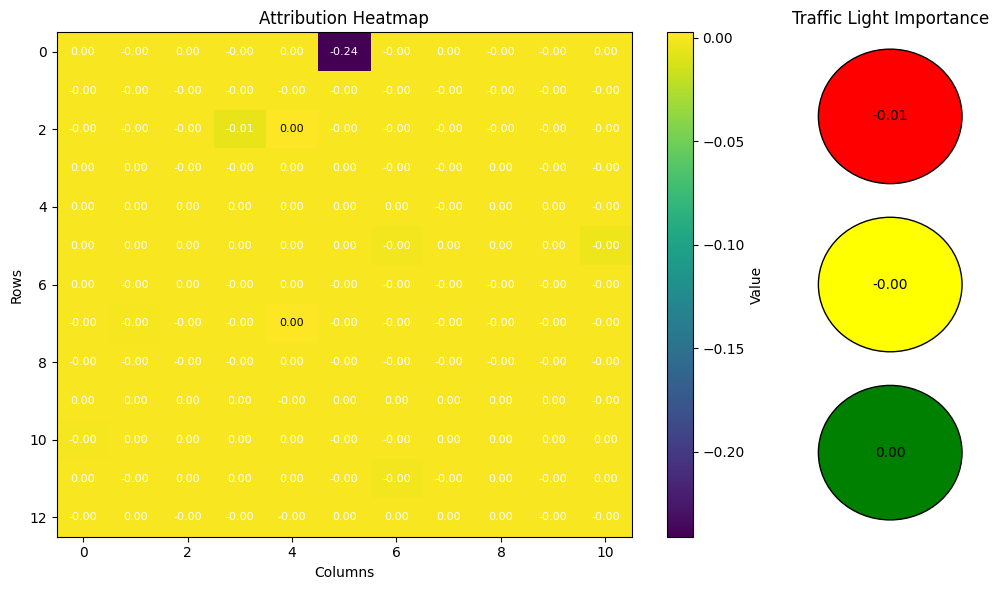

In [5]:
from src.agents.acer.acer_agent import ACERAgent
from src.interpretability import plot_input_layer_weights, plot_weight_attribution
import torch


for env_type, env in zip(["easy", "medium", "hard"], [easy_env, medium_env, hard_env]):
    print(f"Evaluating {env_type}")

    train_parameters = {
        "state_dim": env.grid_shape[0] * env.grid_shape[1] + 3,
        "action_dim": 3,
        "action_space": [0, 1, 2],
        "hidden_dim": 64,
        "gamma": 0.99,
        "episodes": 25_000,
        "learning_rate": 3e-5,
        "timeout": 200,
        "device": "cpu",
        "kl_beta": 0.01,
        "replay_ratio": 5,
        "clip": 10,
        "replay_buffer_size": 200,
        "early_stop": 100,
    }

    agent = ACERAgent(env, train_parameters)
    agent.load(f"../../checkpoints/final_acer/{env_type}.pt")

    plot_input_layer_weights(
        agent.actor_critic,
        env.grid_shape[0],
        env.grid_shape[1],
        input_layer_name="input",
    )

    state, _ = env.reset()
    state_tensor = torch.tensor(agent.transform_state(state)).float().view(1, -1)
    env.render(mode="human")

    def forward_func(input_tensor):
        output_tuple = agent.actor_critic(input_tensor)

        return output_tuple[1]

    plot_weight_attribution(
        agent.actor_critic,
        state_tensor,
        rows=env.grid_shape[0],
        cols=env.grid_shape[1],
        wrapper_func=forward_func,
    )